***Data fields***

***Most of the fields are self-explanatory. The following are descriptions for those that aren't.
***
Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended


CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [386]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [387]:
plt.rcParams["figure.figsize"] = (15,5)

In [388]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission.csv
store.csv
test.csv
train.csv



In [389]:
train=pd.read_csv('../input/train.csv')
store=pd.read_csv('../input/store.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [390]:
train.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

***Check quality of data***

In [391]:
#Check for null values
train.columns[train.isnull().any()]

Index([], dtype='object')

In train data set"No Missing values" problem 

In [392]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [393]:
store.columns[store.isnull().any()]

Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval'],
      dtype='object')

In [394]:
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In store data set"Missing values" problem

In [395]:
store[store['CompetitionDistance'].isnull()].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


 Three store Competitiondistance is not available and We can replace NaN to zero of that three store 

In [396]:
store['CompetitionDistance'].fillna(0, inplace = True)

Totally 354 store isnull in CompetitionOpenSinceMonth/CompetitionOpenSinceYear Already analysed that 3 store of competitiondistance is Nan.

In this 354 store 3 store of CompetitionOpenSinceMonth/CompetitionOpenSinceYear is NaN remaining 531 store Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the mode values.



In [397]:
store[(store['CompetitionDistance'] > 0) & (store['CompetitionOpenSinceMonth'].isnull())].shape

(351, 10)

In [398]:
store['CompetitionOpenSinceMonth'].mode()

0    9.0
dtype: float64

In [399]:
store.loc[(store['CompetitionDistance'] > 0) & (store['CompetitionOpenSinceMonth'].isnull()), 'CompetitionOpenSinceMonth'] = 9.0

In [400]:
store[(store['CompetitionDistance'] > 0) & (store['CompetitionOpenSinceYear'].isnull())].shape

(351, 10)

In [401]:
store['CompetitionOpenSinceYear'].mode()

0    2013.0
dtype: float64

In [402]:
store.loc[(store['CompetitionDistance'] > 0) & (store['CompetitionOpenSinceYear'].isnull()), 'CompetitionOpenSinceYear'] = 2013.0

In [403]:
store[(store['CompetitionDistance'] > 0) & (store['CompetitionOpenSinceYear'].isnull())].shape

(0, 10)

**Promo2**

In [404]:
store[(store['Promo2']==0)].shape

(544, 10)

In [405]:
store[(store['Promo2SinceWeek'].isnull())].shape

(544, 10)

In [406]:
store[(store['Promo2SinceYear'].isnull())].shape

(544, 10)

In [407]:
store[(store['PromoInterval'].isnull())].shape

(544, 10)

544 promo2 is zero

Promo2SinceWeek,Promo2SinceYear,PromoInterval total Nan is 544 . Analysed no problem


In [408]:
store[(store['Promo2'] == 1) & (store['Promo2SinceWeek'].isnull())].shape

(0, 10)

In [409]:
store[(store['Promo2'] == 1) & (store['Promo2SinceYear'].isnull())].shape

(0, 10)

In [410]:
store[(store['Promo2'] == 1) & (store['PromoInterval'].isnull())].shape

(0, 10)

I checked if promo2 is 1 the Promo2SinceWeek,Promo2SinceYear,PromoInterval Nan is available or not 
It's no 

In [411]:
#store['Promo2SinceYear'].fillna(0, inplace = True)
#store['Promo2SinceWeek'].fillna(0, inplace = True)
#store['PromoInterval'].fillna(0, inplace = True)

In [412]:
#store['CompetitionOpenSinceMonth'].fillna(0, inplace = True)
#store['CompetitionOpenSinceYear'].fillna(0, inplace = True)

In [413]:
#"Joining train set with an additional store information."

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train=pd.read_csv('../input/train.csv')
result = pd.merge(train,
                 store,
                 on='Store')

**Check the unique value of all feature in result data set**

 **Store**

In [415]:
result['Store'].unique()

array([   1,    2,    3, ..., 1113, 1114, 1115])

**DayOfWeek**

In [416]:
result['DayOfWeek'].unique()

array([5, 4, 3, 2, 1, 7, 6])

In [417]:
train[(train['Open']==1) & (train['DayOfWeek']==7)&(train['Sales']>0)].shape

(3593, 9)

In [418]:
train[(train['Open']==1) & (train['DayOfWeek']!=7)&(train['Sales']>0)].shape

(840745, 9)

Sunday sales is more compare to the all days

In [419]:
train[(train['Open']==0) & (train['DayOfWeek']==7) & (train['Sales']>0)].shape

(0, 9)

In [420]:
train[(train['Open']==0) & (train['DayOfWeek']==7) & (train['Sales']==0)].shape

(141137, 9)

141137 times, the stores were closed for no reason (No Holidays o Sunday)

Rossman described clearly, that they were undergoing refurbishments sometimes and had to close. 

**Date**

I am dealing with time series data so it will probably serve us to extract dates for further analysis. 

In [422]:
# data extraction
result['Date'] = pd.to_datetime(result['Date'])

In [423]:
result['Year'] = result['Date'].dt.year
result['Month'] = result['Date'].dt.month
result['Day'] = result['Date'].dt.day
result['dayOfWeek'] = result['Date'].dt.day_name()
result['WeekOfYear'] = result['Date'].dt.weekofyear

result.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,dayOfWeek,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,Friday,31
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,30,Thursday,31
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,29,Wednesday,31
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,28,Tuesday,31
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,27,Monday,31


**Sales**

In [424]:
result['Sales'].unique()

array([ 5263,  5020,  4782, ..., 20362, 18841, 21237])

In [425]:
result[result['Sales'] == 0].shape

(172871, 23)

In [426]:
# opened stores with zero sales
train[(train['Open']==1) & (train['Sales']==0)].shape


(54, 9)

Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data,  Analysed that there were external factors involved, for example manifestations.

In [427]:
result[(result['Sales'] == 0) & (result['Customers'] >0)].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,dayOfWeek,WeekOfYear
864013,948,4,2013-04-25,0,5,1,1,0,0,b,...,2013.0,0,NaN,NaN,NaN,2013,4,25,Thursday,17
1003331,1100,2,2014-04-29,0,3,1,1,0,0,a,...,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2014,4,29,Tuesday,18


In [428]:
result.drop(result.index[[864013,1003331]], inplace=True)

Two stores customers is available but sales is zero

Analysed that data is missing i droped that two rows

**Customers**

In [430]:
result[result['Customers'] == 0].shape

(172869, 23)

**Open**

In [431]:
result['Open'].unique()

array([1, 0])

In [432]:
result[result['Open'] == 0].shape

(172817, 23)

In [433]:
result[(result['Customers'] >= 1) & (result['Open'] == 0)].shape

(0, 23)

**Promo**

In [434]:
result['Promo'].unique()

array([1, 0])

In [435]:
result[(result['Promo'] == 1)].shape

(388078, 23)

In [436]:
result[(result['Sales'] == 0) & (result['Promo'] == 1)].shape

(11203, 23)

In [437]:
result[(result['Sales'] == 0) & (result['Promo'] == 0)].shape

(161666, 23)

In [438]:
result[(result['Open'] == 0) & (result['Promo'] == 1)].shape

(11184, 23)

**StateHoliday**

In [439]:
result['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [440]:
result.loc[result['StateHoliday'] == '0', 'StateHoliday'] = 0

In stateholiday '0' string is available i replaced '0' to zero

**SchoolHoliday**

In [441]:
result['SchoolHoliday'].unique()

array([1, 0])

**StoreType**

In [442]:
result['StoreType'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

**Assortment**

In [443]:
result['Assortment'].unique()

array(['a', 'c', 'b'], dtype=object)

**CompetitionOpenSinceYear**

In [445]:
result['CompetitionOpenSinceYear'].unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
       2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961., 1995.,
       2001.,   nan, 1990., 1994., 1900., 1998.])

**CompetitionOpenSinceMonth**

In [446]:
result['CompetitionOpenSinceMonth'].unique()

array([ 9., 11., 12.,  4., 10.,  8.,  3.,  6.,  5.,  1.,  2.,  7., nan])

**Promo2**

In [447]:
result['Promo2'].unique()

array([0, 1])

In [448]:
result[(result['Promo2'] == 1)].shape

(509177, 23)

In [449]:
result[(result['Promo'] == 1)].shape

(388078, 23)

**Promo2SinceWeek**

In [450]:
result['Promo2SinceWeek'].unique()

array([nan, 13., 14.,  1., 45., 40., 26., 22.,  5.,  6., 10., 31., 37.,
        9., 39., 27., 18., 35., 23., 48., 36., 50., 44., 49., 28.])

**Promo2SinceYear**

In [451]:
result['Promo2SinceYear'].unique()

array([  nan, 2010., 2011., 2012., 2009., 2014., 2015., 2013.])

**PromoInterval**

In [452]:
result['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

**CompetitionOpen**

To complete our preliminary data analysis,  Analysed to add variables describing the period of time during which competition and promotion were opened:

In [453]:
result['CompetitionOpen'] = 12 * (result.Year - result.CompetitionOpenSinceYear) + (result.Month - result.CompetitionOpenSinceMonth)
result.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,dayOfWeek,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,31,Friday,31,82.0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,30,Thursday,31,82.0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,29,Wednesday,31,82.0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,28,Tuesday,31,82.0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,0,NaN,NaN,NaN,2015,7,27,Monday,31,82.0


In [454]:
result[(result['CompetitionOpen'].isnull())].shape

(2642, 24)

In [456]:
result[(result['CompetitionOpen']==0)].shape

(16035, 24)

In [457]:
result[(result['CompetitionOpen']>0)].shape

(828572, 24)

In [458]:
result[(result['CompetitionOpen']<0)].shape

(169958, 24)

In [459]:
result[(result['CompetitionOpen']<0)].CompetitionOpen.unique()

array([ -1.,  -2.,  -3.,  -4.,  -5.,  -6.,  -7.,  -8.,  -9., -10., -11.,
       -12., -13., -14., -15., -16., -17., -18., -19., -20., -21., -22.,
       -23., -24., -25., -26., -27., -28., -29., -30., -31.])

In [460]:
result.loc[(result['CompetitionOpen'].isnull()), 'CompetitionOpen'] = -15

Analysed that postive ,zero value have CompetitionOpen and negative , NaN value have not CompetitionOpen

**promoopen**

In [461]:
result['PromoOpen'] = 12 * (result.Year - result.Promo2SinceYear) + (result.WeekOfYear - result.Promo2SinceWeek) / 4.0

In [462]:
result[(result['PromoOpen'].isnull())].shape

(508030, 25)

In [463]:
result[(result['PromoOpen']==0)].shape

(1273, 25)

In [464]:
result[(result['PromoOpen']>0)].shape

(438018, 25)

In [465]:
result[(result['PromoOpen']<0)].shape

(69886, 25)

In [466]:
result[(result['PromoOpen']<0)].PromoOpen.unique()

array([ -3.25,  -3.5 ,  -3.75,  -4.  ,  -4.25,  -4.5 ,  -4.75,  -5.  ,
        -5.25,  -5.5 ,  -5.75,  -6.  ,  -6.25,  -6.5 ,  -6.75,  -7.  ,
        -7.25,  -7.5 ,  -7.75,  -8.  ,  -8.25,  -8.5 ,  -8.75,  -9.  ,
        -9.25,  -9.5 ,  -9.75, -21.75, -10.  , -10.25, -10.5 , -10.75,
       -11.  , -11.25, -11.5 , -11.75, -12.  , -12.25, -12.5 , -12.75,
       -13.  , -13.25, -13.5 , -13.75, -14.  , -14.25, -14.5 , -14.75,
       -15.  , -15.25, -15.5 , -15.75, -16.  , -16.25, -16.5 , -16.75,
       -17.  , -17.25, -17.5 , -17.75, -18.  , -18.25, -18.5 , -18.75,
       -19.  , -19.25, -19.5 , -19.75, -20.  , -20.25, -20.5 , -20.75,
       -21.  , -21.25, -21.5 ,  -0.25,  -0.5 ,  -0.75,  -1.  ,  -1.25,
        -1.5 ,  -1.75,  -2.  ,  -2.25,  -2.5 ,  -2.75,  -3.  , -25.25,
       -22.  , -22.25, -22.5 , -22.75, -23.  , -23.25, -23.5 , -23.75,
       -24.  , -24.25, -24.5 , -24.75, -25.  , -27.25, -25.5 , -25.75,
       -26.  , -26.25, -26.5 , -26.75, -27.  , -29.5 , -27.5 , -27.75,
      

In [467]:
result.loc[(result['PromoOpen'].isnull()), 'PromoOpen'] = -15

 Analysed that postive ,zero value have PromoOpen and negative , NaN value have not PromoOpen

In [468]:
result.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,dayOfWeek,WeekOfYear,CompetitionOpen,PromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,Friday,31,82.0,-15.0
1,1,4,2015-07-30,5020,546,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,30,Thursday,31,82.0,-15.0
2,1,3,2015-07-29,4782,523,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,29,Wednesday,31,82.0,-15.0
3,1,2,2015-07-28,5011,560,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,28,Tuesday,31,82.0,-15.0
4,1,1,2015-07-27,6102,612,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,27,Monday,31,82.0,-15.0


In [469]:
result.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
Year                                  int64
Month                                 int64
Day                                   int64
dayOfWeek                            object
WeekOfYear                      

In [470]:
result.drop(columns=['Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','dayOfWeek','Day'], inplace=True)

In [242]:
categorical_columns = ['Open', 'Promo','DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','PromoInterval','Promo2','Year','Month','WeekOfYear']
numeric_columns = ['Store','Sales', 'Customers', 'CompetitionDistance','CompetitionOpen','PromoOpen']

In [92]:
result.dtypes

Store                    int64
DayOfWeek                int64
Sales                    int64
Customers                int64
Open                     int64
Promo                    int64
StateHoliday            object
SchoolHoliday            int64
StoreType               object
Assortment              object
CompetitionDistance    float64
Promo2                   int64
PromoInterval           object
Year                     int64
Month                    int64
WeekOfYear               int64
CompetitionOpen        float64
PromoOpen              float64
dtype: object

**Univariate Analysis**

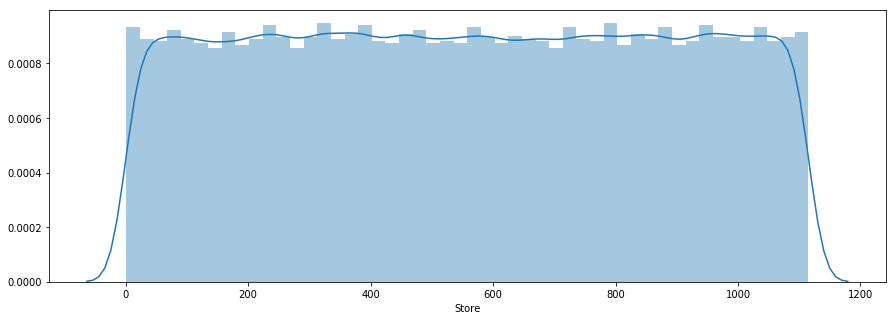

In [93]:
sns.distplot(result['Store'])

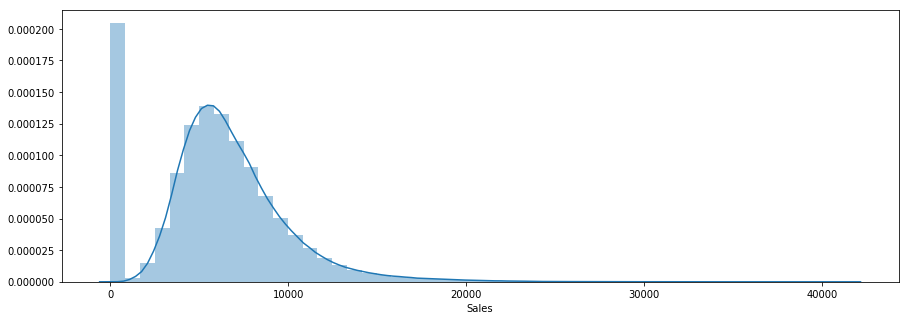

In [94]:
sns.distplot(result['Sales'])

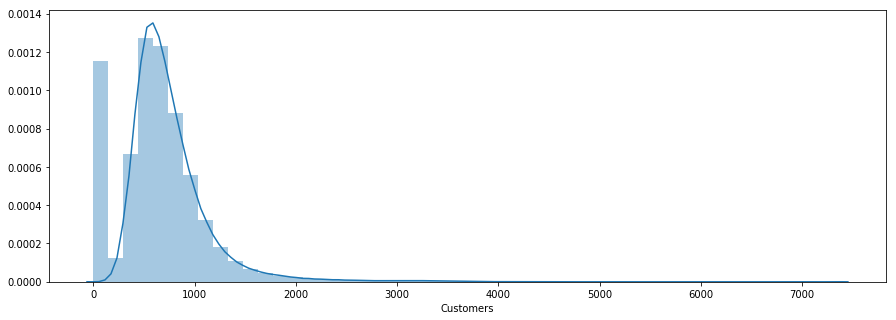

In [95]:
sns.distplot(result['Customers'])

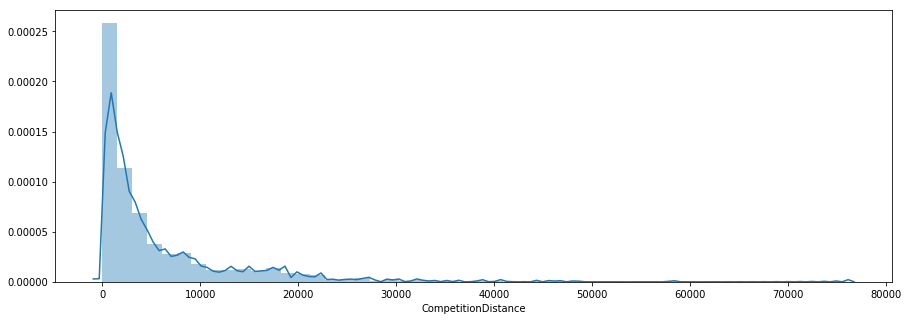

In [96]:
sns.distplot(result['CompetitionDistance'])

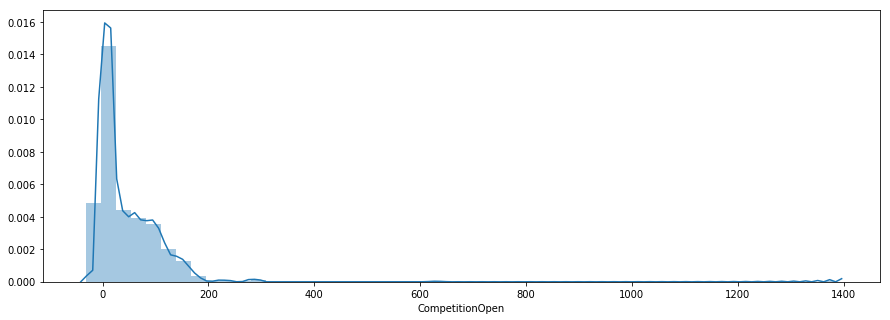

In [97]:
sns.distplot(result['CompetitionOpen'])

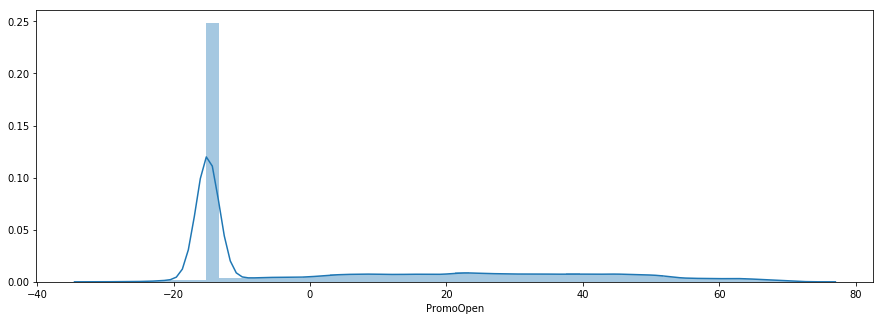

In [98]:
sns.distplot(result['PromoOpen'])

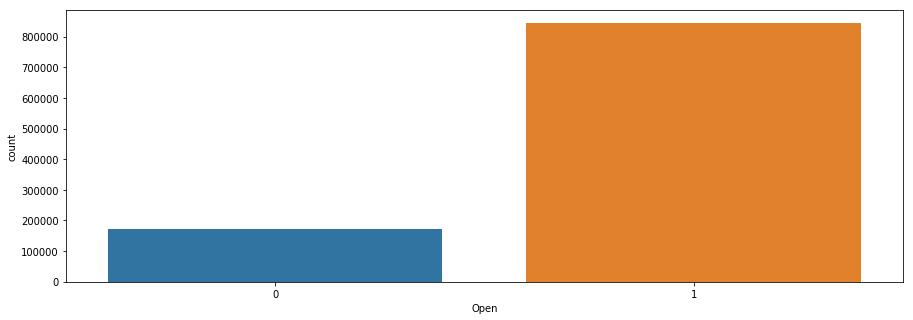

In [99]:
sns.countplot(x=result['Open'], data=result)

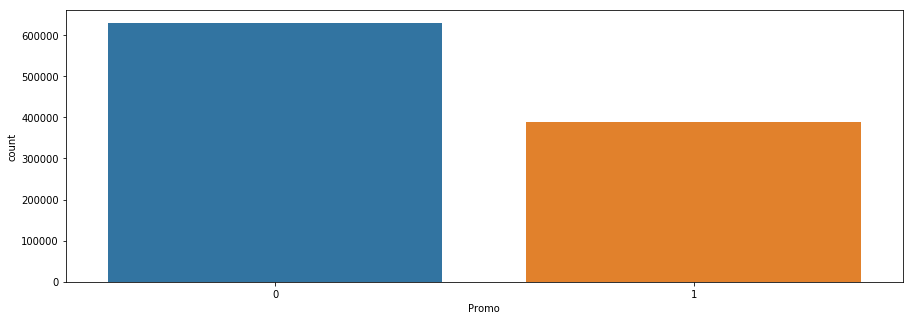

In [100]:
sns.countplot(x=result['Promo'], data=result)

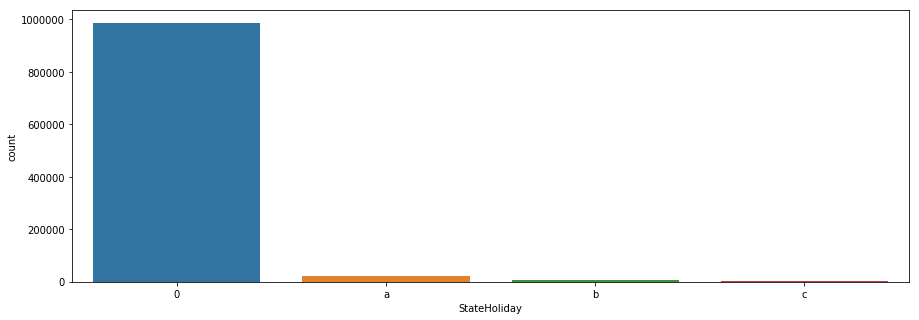

In [101]:
sns.countplot(x=result['StateHoliday'], data=result)

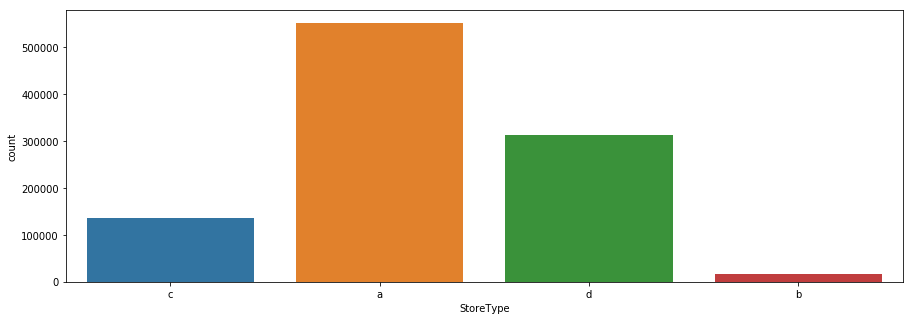

In [102]:
sns.countplot(x=result['StoreType'], data=result)

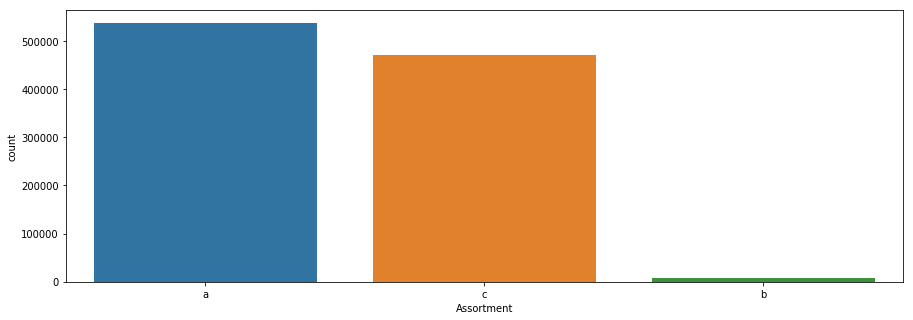

In [103]:
sns.countplot(x=result['Assortment'], data=result)

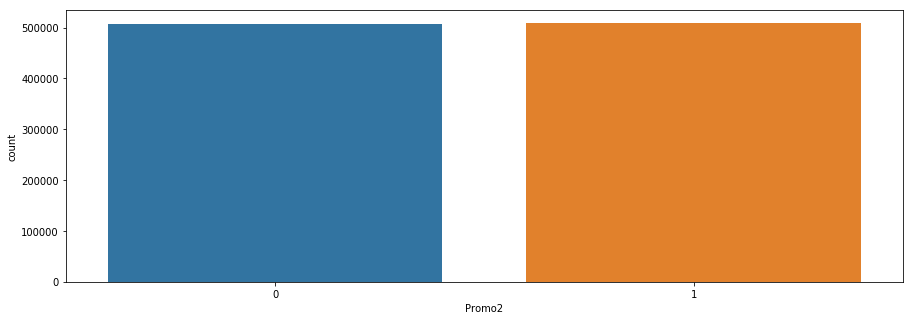

In [104]:
sns.countplot(x=result['Promo2'], data=result)

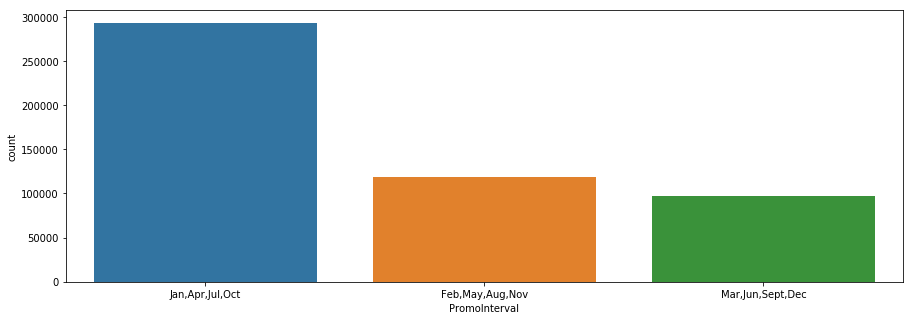

In [105]:
sns.countplot(x=result['PromoInterval'], data=result)

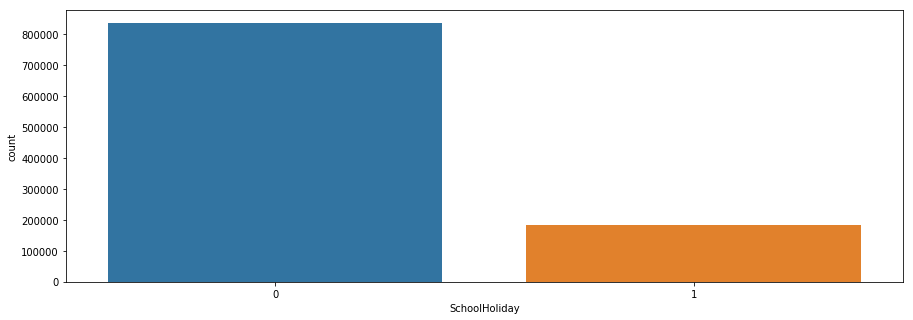

In [106]:
sns.countplot(x=result['SchoolHoliday'], data=result)

In [107]:
numeric_columns

['Store',
 'Sales',
 'Customers',
 'CompetitionDistance',
 'CompetitionOpen',
 'PromoOpen']

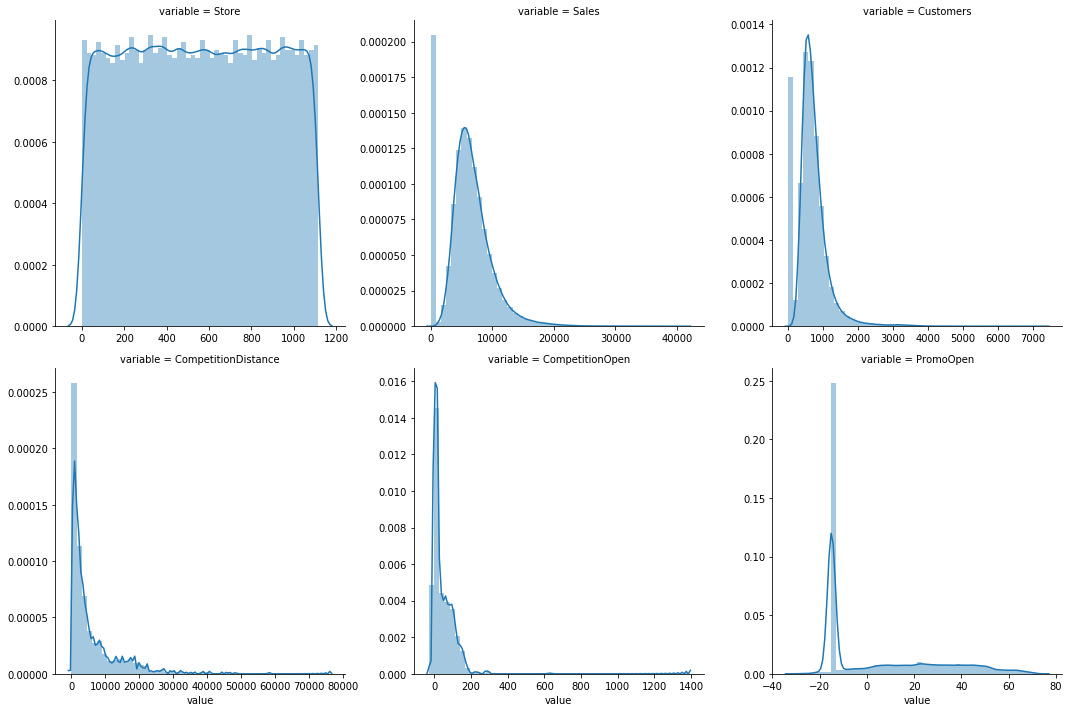

In [108]:
f = pd.melt(result, value_vars=numeric_columns)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height = 5)
g = g.map(sns.distplot, "value")

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


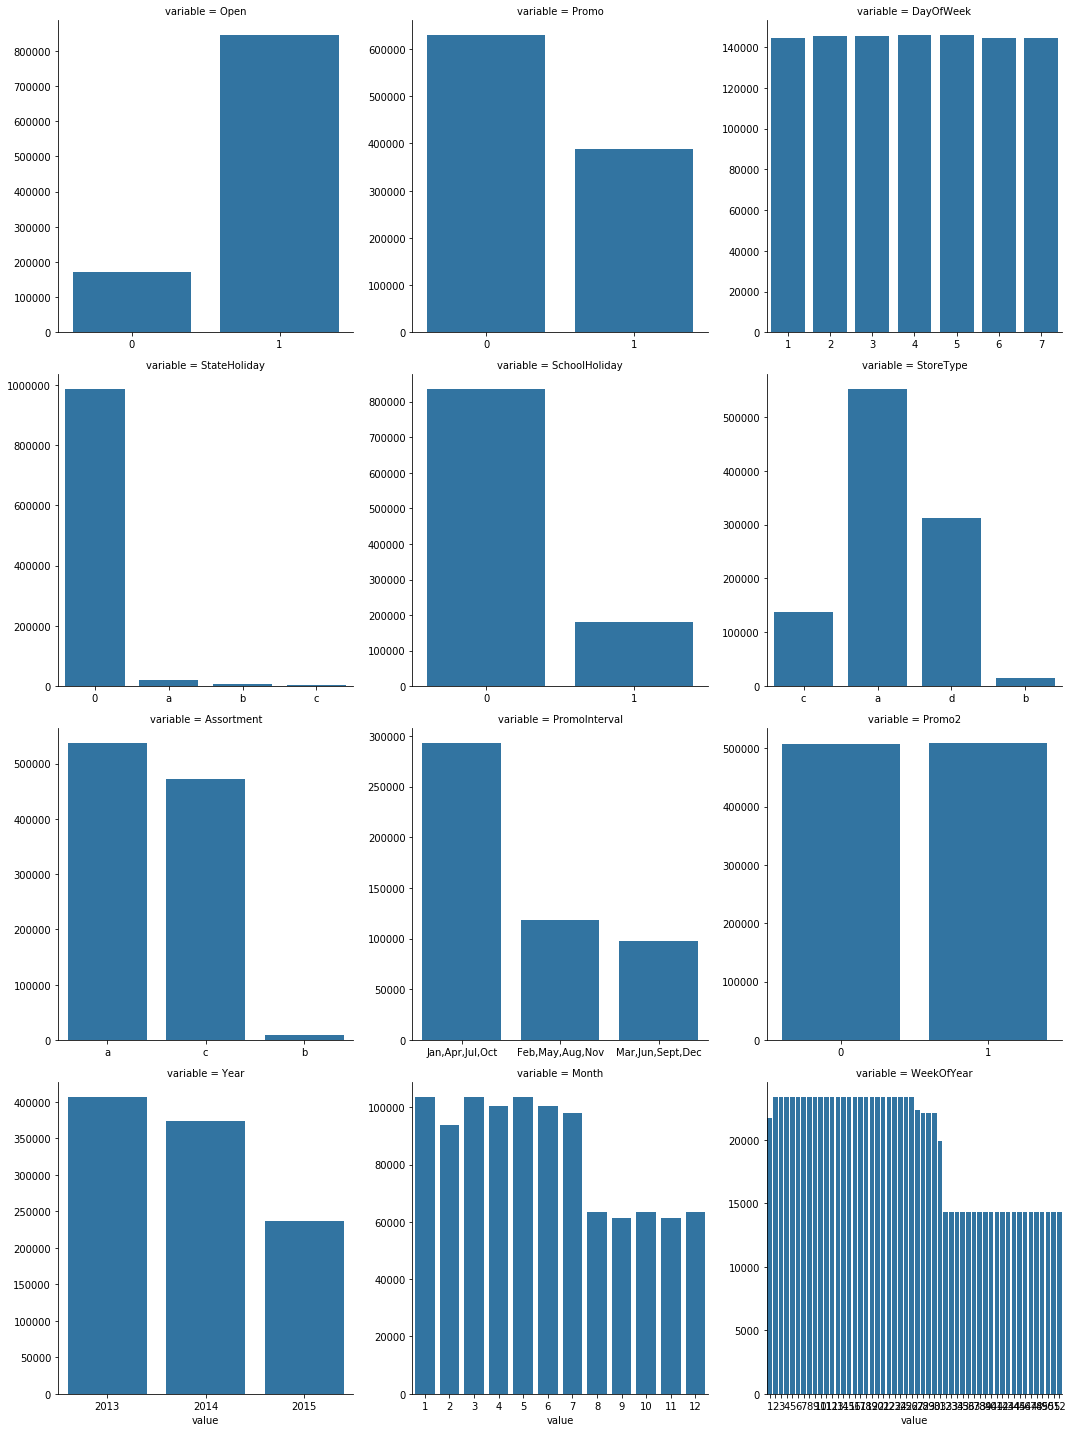

In [109]:
#Create a countplot
f = pd.melt(result, value_vars=categorical_columns)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, size = 5)
g = g.map(sns.countplot, "value")

**Bivariate Analysis**

Relationship of a feature with target variable

In [110]:
categorical_columns

['Open',
 'Promo',
 'DayOfWeek',
 'StateHoliday',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'PromoInterval',
 'Promo2',
 'Year',
 'Month',
 'WeekOfYear']

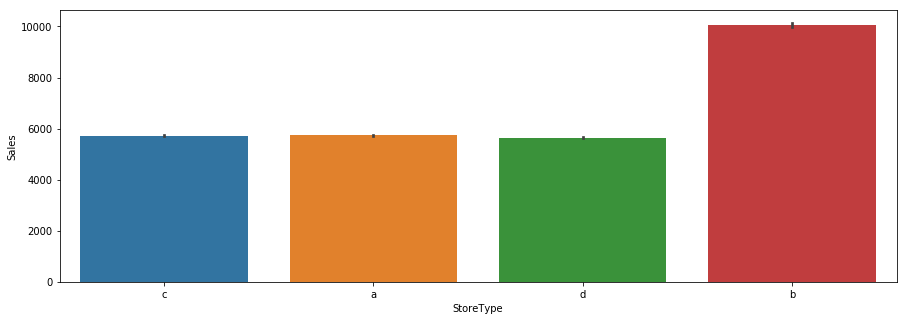

In [111]:
sns.barplot(x='StoreType', y='Sales', data=result)

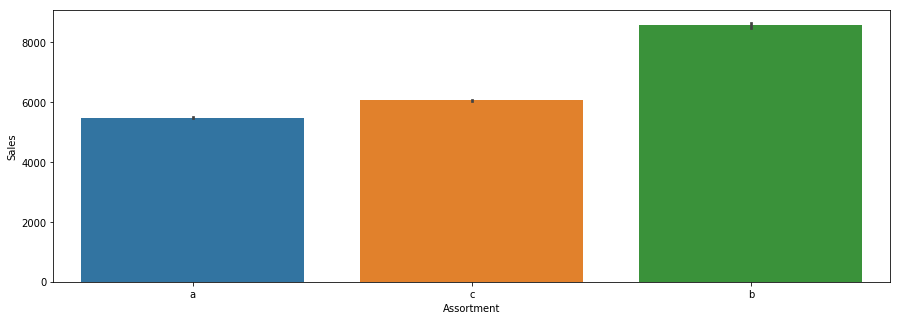

In [112]:
sns.barplot(x='Assortment', y='Sales', data=result)

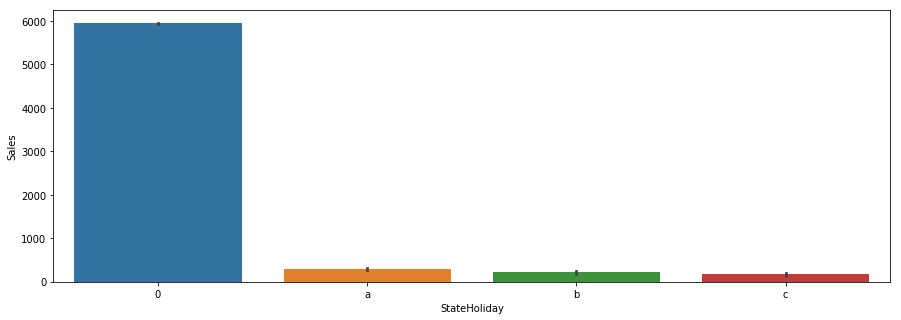

In [113]:
sns.barplot(x='StateHoliday', y='Sales', data=result)

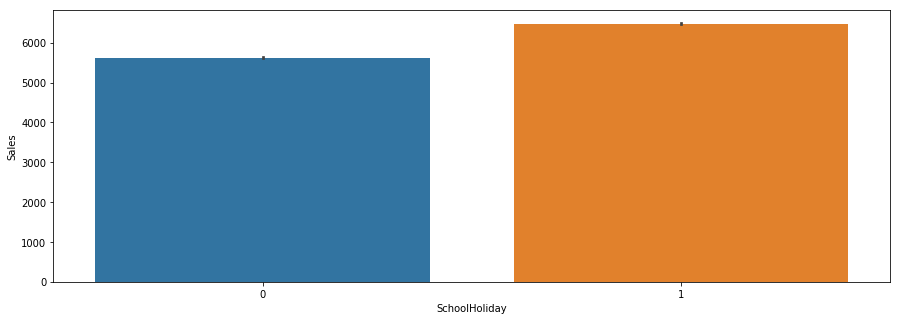

In [114]:
sns.barplot(x='SchoolHoliday', y='Sales', data=result)

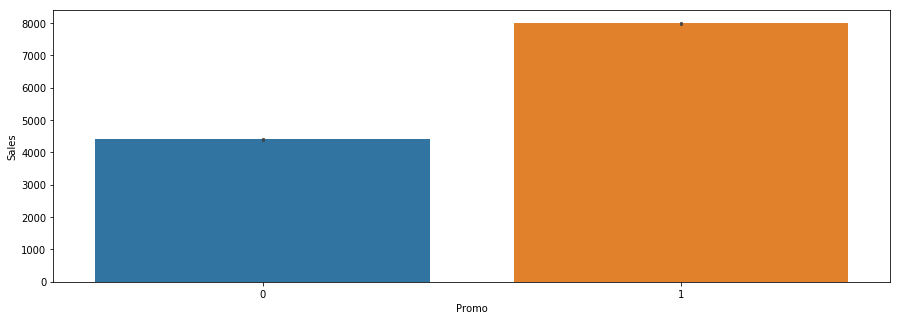

In [115]:
sns.barplot(x='Promo', y='Sales', data=result)

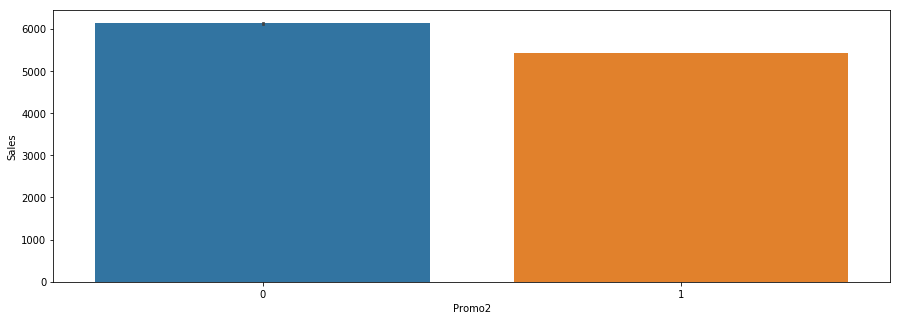

In [116]:
sns.barplot(x='Promo2', y='Sales', data=result)

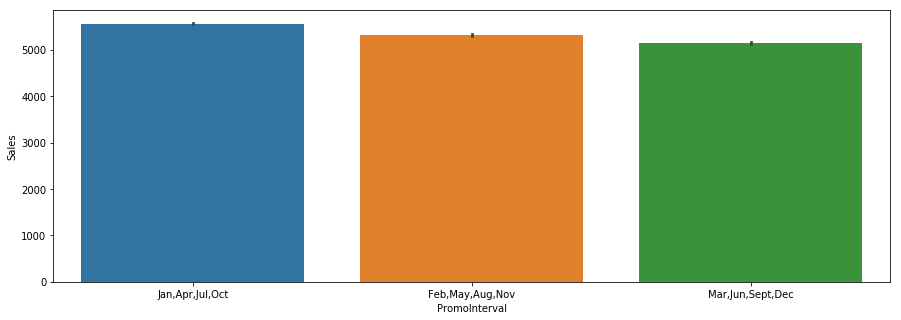

In [117]:
sns.barplot(x='PromoInterval', y='Sales', data=result)

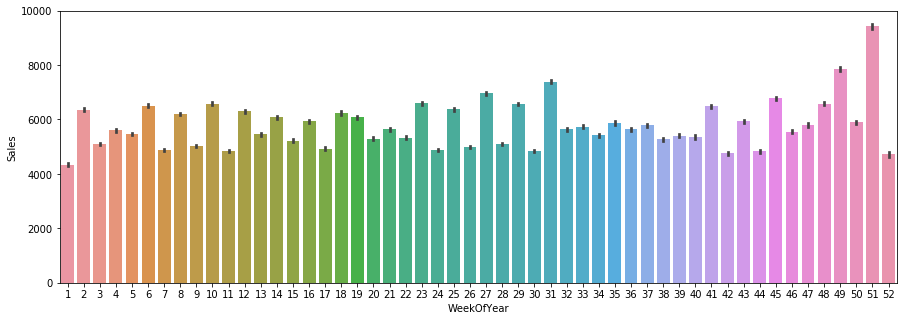

In [118]:
sns.barplot(x='WeekOfYear', y='Sales', data=result)

In [119]:
numeric_columns

['Store',
 'Sales',
 'Customers',
 'CompetitionDistance',
 'CompetitionOpen',
 'PromoOpen']

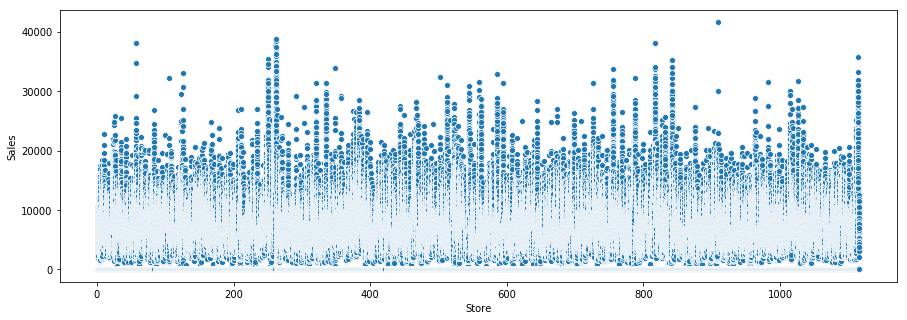

In [120]:
sns.scatterplot(x='Store',y='Sales', data=result)

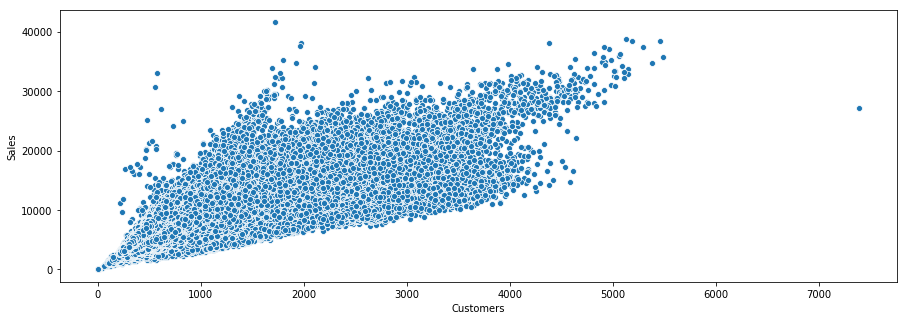

In [121]:
sns.scatterplot(x='Customers',y='Sales', data=result)

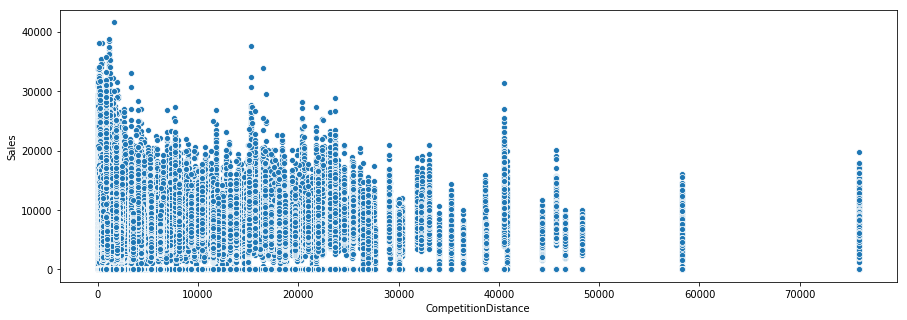

In [122]:
sns.scatterplot(x='CompetitionDistance',y='Sales', data=result)

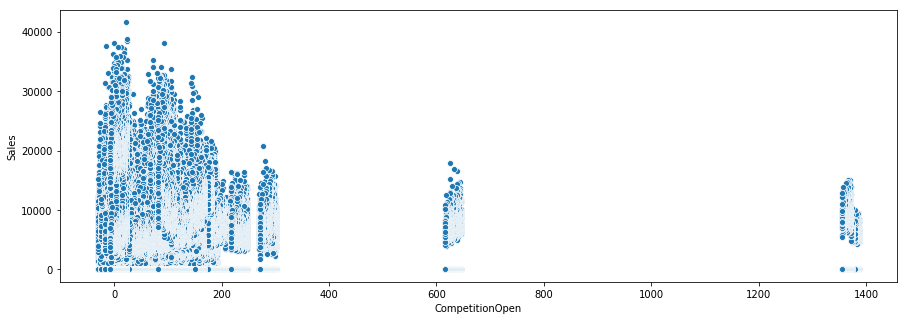

In [123]:
sns.scatterplot(x='CompetitionOpen',y='Sales', data=result)

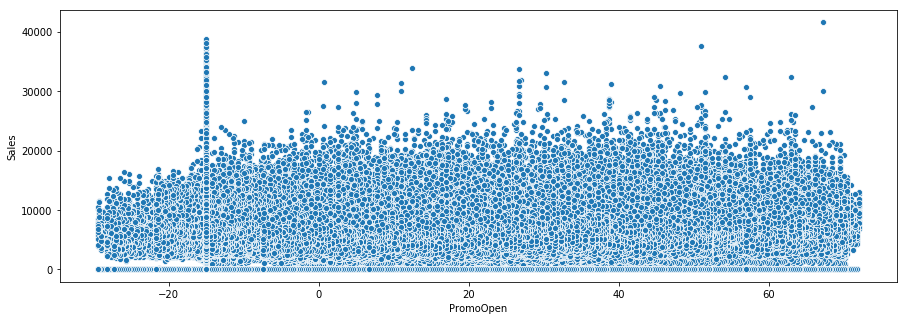

In [124]:
sns.scatterplot(x='PromoOpen',y='Sales', data=result)

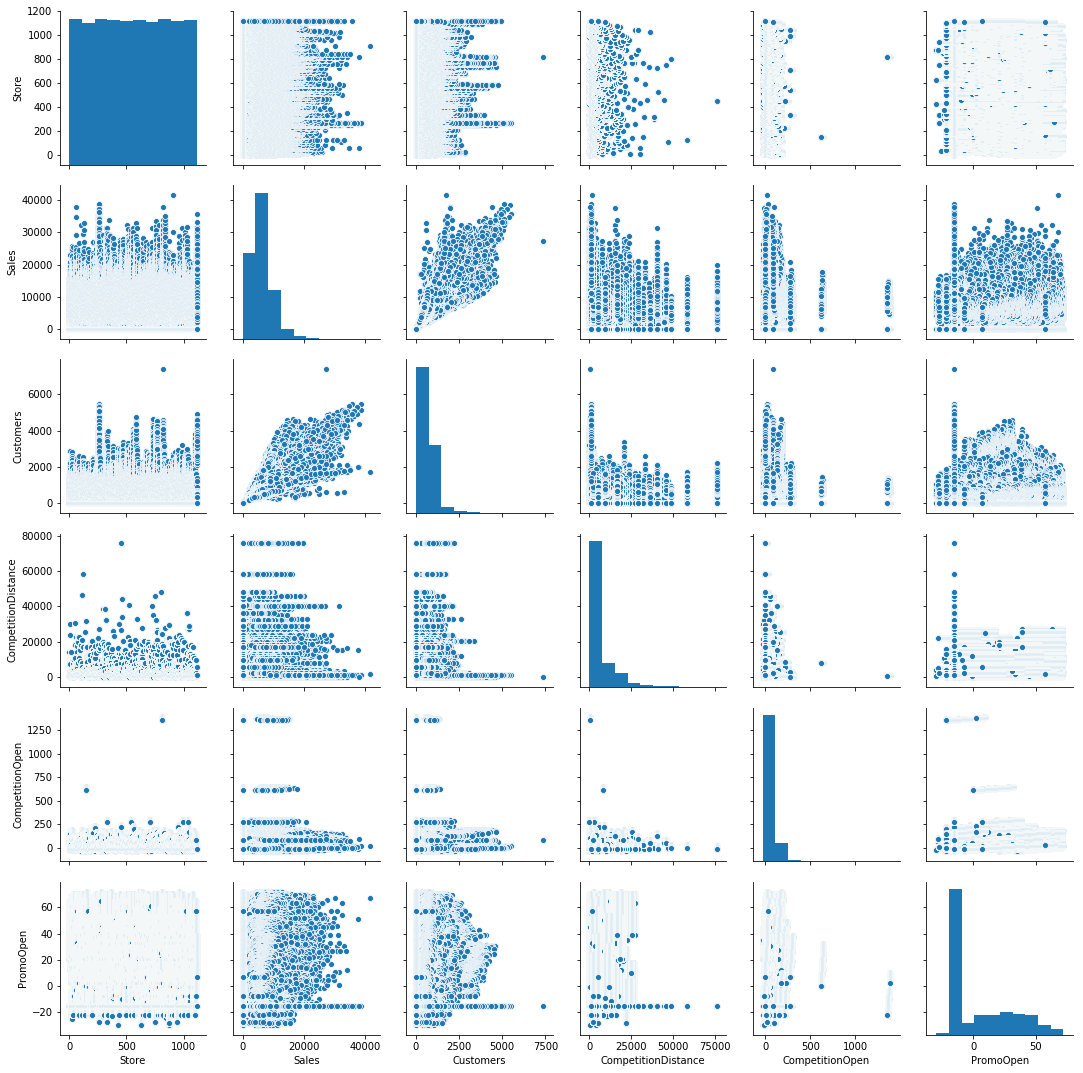

In [125]:
sns.pairplot(result[numeric_columns])

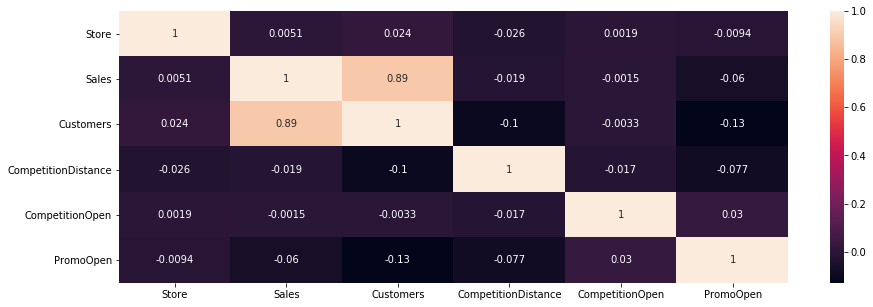

In [126]:
corr = result[numeric_columns].corr()
sns.heatmap(corr, annot=True)

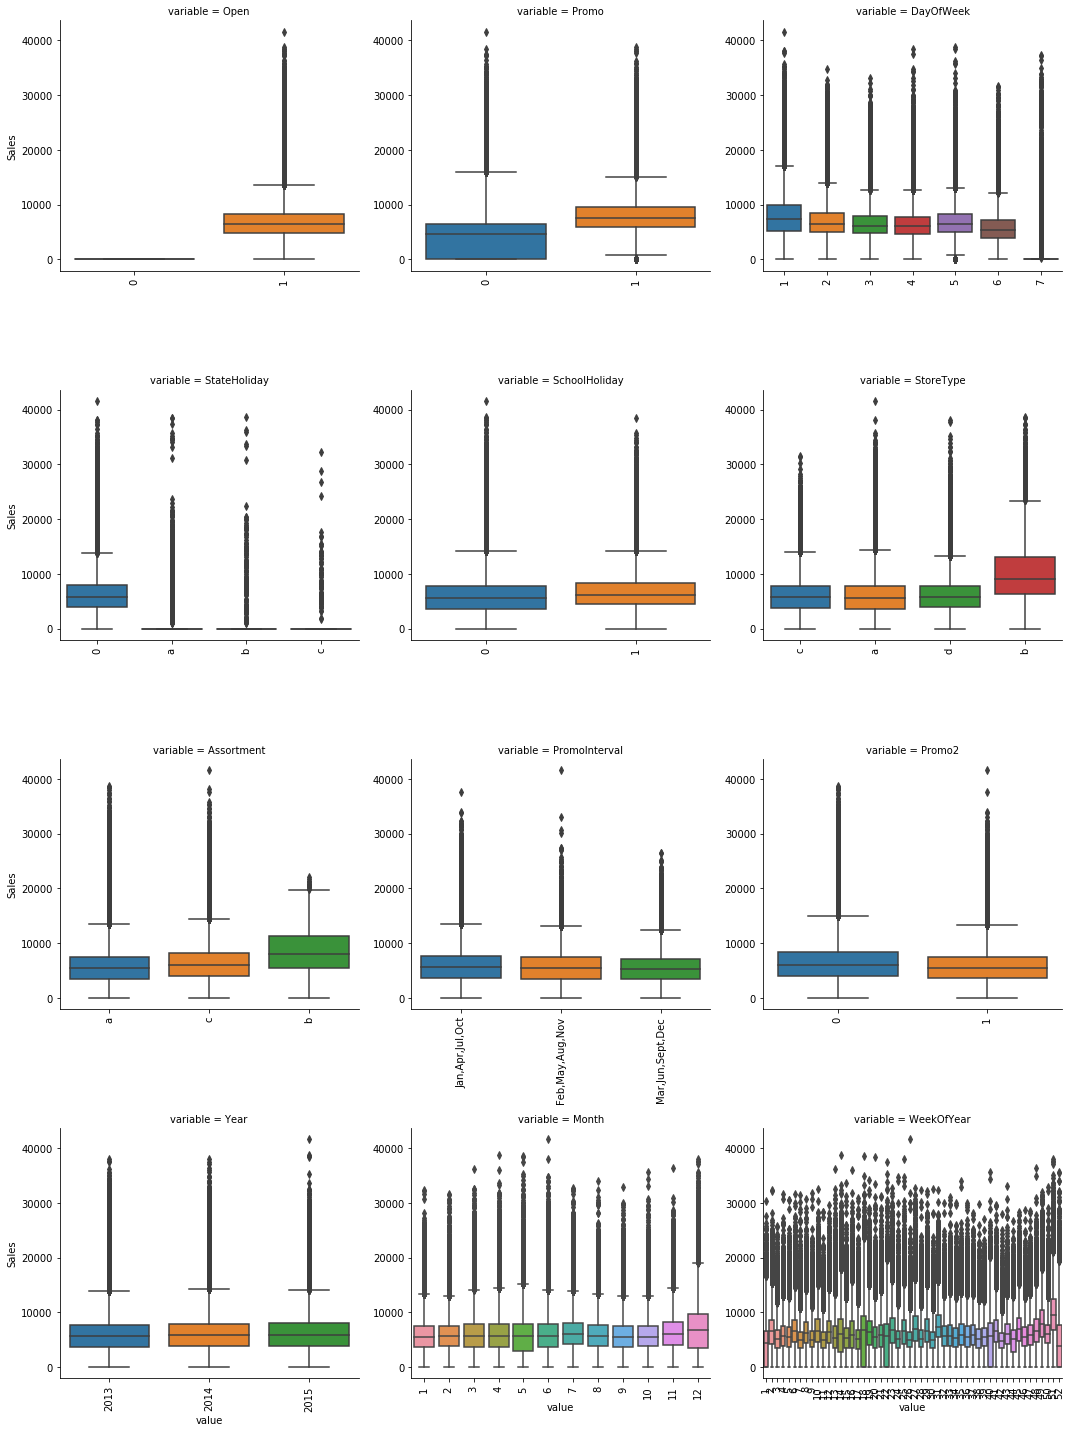

In [127]:
#Categorical variables vs target variable
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(result, id_vars=['Sales'], value_vars=categorical_columns)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5)
g.map(boxplot, "value", "Sales")

In [471]:
result.dtypes

Store                    int64
DayOfWeek                int64
Sales                    int64
Customers                int64
Open                     int64
Promo                    int64
StateHoliday            object
SchoolHoliday            int64
StoreType               object
Assortment              object
CompetitionDistance    float64
Promo2                   int64
PromoInterval           object
Year                     int64
Month                    int64
WeekOfYear               int64
CompetitionOpen        float64
PromoOpen              float64
dtype: object

**Normalization**

2.9312720665226597

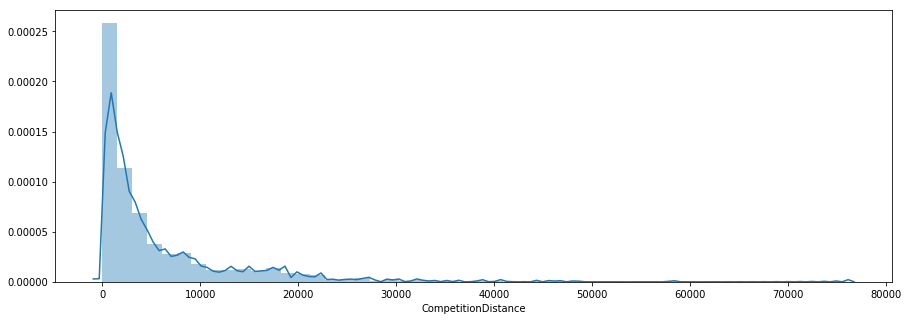

In [472]:
sns.distplot(result['CompetitionDistance'])
result['CompetitionDistance'].skew()

Data cleaning: 

Looks like CompetitionDistance is 0
Looks like having outliers 
Feature Engineering: 
Positively skewed

0.6597444481910483

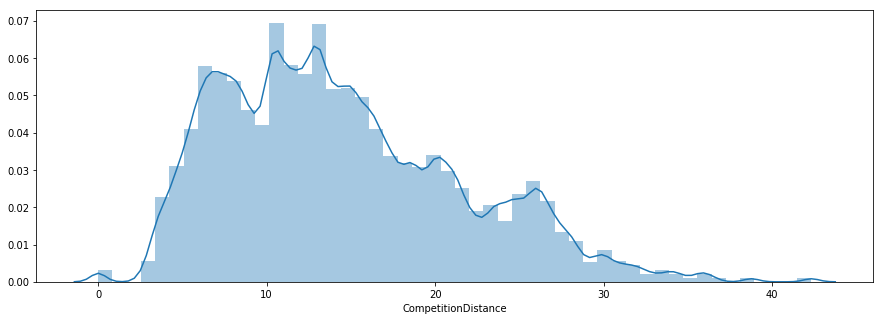

In [473]:
sns.distplot(np.cbrt(result['CompetitionDistance']))
np.cbrt(result['CompetitionDistance']).skew()

In [474]:
result['CompetitionDistance']=np.cbrt(result['CompetitionDistance'])

7.6450947233159745

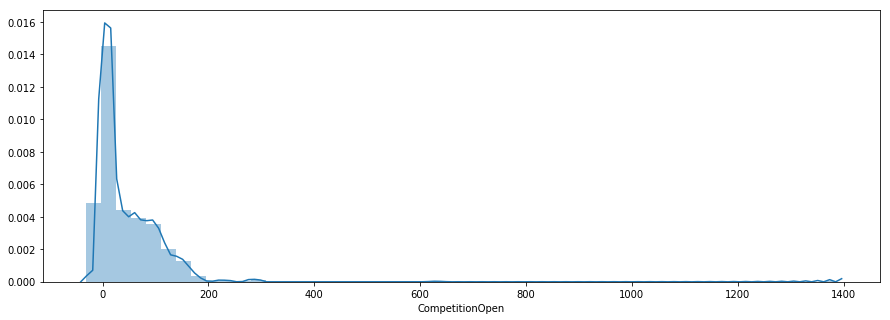

In [475]:
sns.distplot(result['CompetitionOpen'])
result['CompetitionOpen'].skew()

Looks like CompetitionOpen is 0 Looks like having outliers Feature Engineering: Positively skewed

-0.7471270774140909

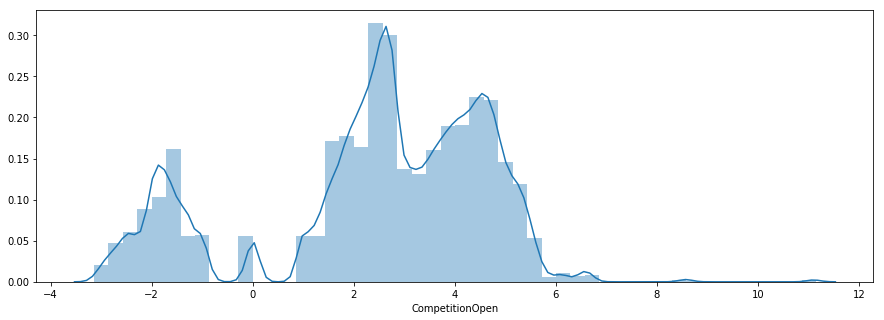

In [476]:
sns.distplot(np.cbrt(result['CompetitionOpen']))
np.cbrt(result['CompetitionOpen']).skew()

In [477]:
result['CompetitionOpen']=np.cbrt(result['CompetitionOpen'])

0.8542745138768614

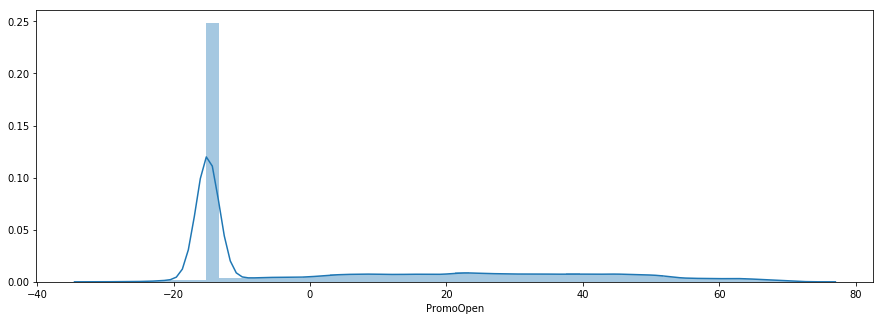

In [478]:
sns.distplot(result['PromoOpen'])
result['PromoOpen'].skew()

Looks like PromoOpen is 0 Looks like having outliers Feature Engineering: Positively skewed

0.35240668968101657

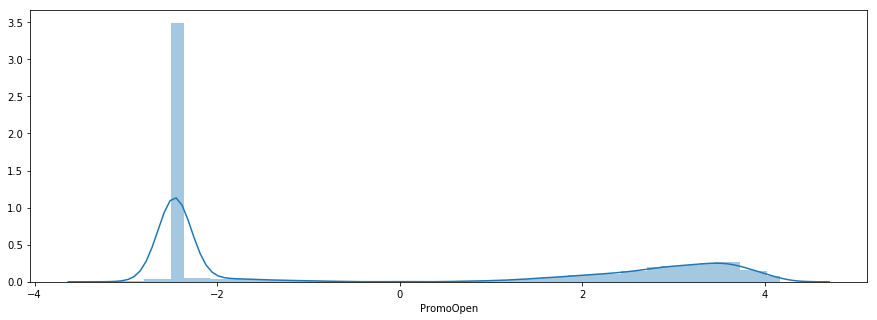

In [479]:
sns.distplot(np.cbrt(result['PromoOpen']))
np.cbrt(result['PromoOpen']).skew()

In [480]:
result['PromoOpen']=np.cbrt(result['PromoOpen'])

 **Data Encoding**

In [481]:
result.loc[result['Assortment']=='a', 'Assortment'] = 1
result.loc[result['Assortment']=='b', 'Assortment'] = 2
result.loc[result['Assortment']=='c', 'Assortment'] = 3

In [482]:

result.loc[result['StateHoliday']=='a', 'StateHoliday'] = 1
result.loc[result['StateHoliday']=='b', 'StateHoliday'] = 1
result.loc[result['StateHoliday']=='c', 'StateHoliday'] = 1

In [483]:
result['PromoInterval'] = result['PromoInterval'].map({np.nan: '0', 'Jan,Apr,Jul,Oct': '1', 'Feb,May,Aug,Nov':'2', 'Mar,Jun,Sept,Dec':'3' })

**One-hot Encoding**

In [484]:
result=pd.get_dummies(result, columns=['StoreType']) 

In [485]:
result.columns[result.isnull().any()]

Index([], dtype='object')

In [486]:
result.drop(columns=['Customers','Store'], inplace=True)

Created two variable trainwithsales and trainwithoutsales 

In [487]:
trainWithSales = result[result['Sales'] != 0]

In [488]:
trainWithoutSales = result[result['Sales'] == 0]

Analysed to using two model one is LogisticRegression for without sales and other one is RandomForestRegressor for with sales.
Hassales is a new feature for  LogisticRegression problem 

In [489]:
result['Hassales']=np.where(result['Sales']>0,1,0)
result.head()

,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,Assortment,CompetitionDistance,Promo2,PromoInterval,Year,Month,WeekOfYear,CompetitionOpen,PromoOpen,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Hassales
0,5,5263,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0,1
1,4,5020,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0,1
2,3,4782,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0,1
3,2,5011,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0,1
4,1,6102,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0,1


In [490]:
sales=result['Sales'].copy()
hassales=result['Hassales'].copy()
result.drop(columns=['Sales','Hassales'],inplace=True)
result.head()

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Assortment,CompetitionDistance,Promo2,PromoInterval,Year,Month,WeekOfYear,CompetitionOpen,PromoOpen,StoreType_a,StoreType_b,StoreType_c,StoreType_d
0,5,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0
1,4,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0
2,3,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0
3,2,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0
4,1,1,1,0,1,1,10.829321,0,0,2015,7,31,4.344481,-2.466212,0,0,1,0


why logistic regression is used in regression problem? 

In  target variable (sales) having without sales (zero) and with sales.if i do the both sales in regression problem i have problem in zero sales and i can't able to modified skew that why i am using logistic regression 

LogisticRegression model

In [491]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
logreg= LogisticRegression()
score=cross_val_score(logreg,result,hassales,cv=5)
print('Accuracy:', score.mean())

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

Accuracy: 0.9999252854394358


In [492]:
logreg.fit(result,hassales)
logreg.score(result,hassales)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.999948879628237

In [493]:
#trainWithSales = result[result['Sales'] != 0]
trainWithSales.shape

(844338, 19)

In [494]:
#trainWithoutSales = result[result['Sales'] == 0]
trainWithoutSales.shape

(172869, 19)

-0.10968460576537623

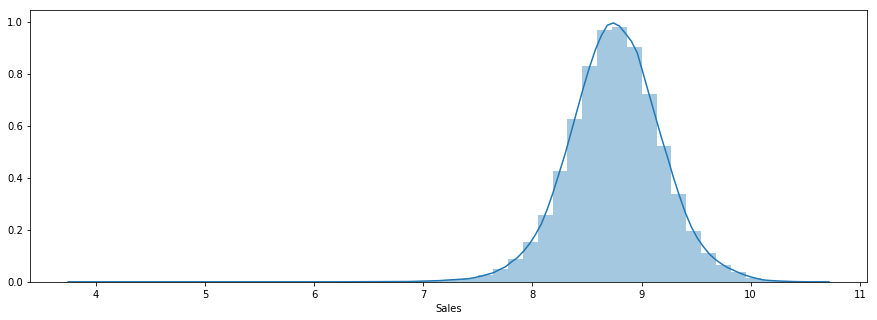

In [495]:
sns.distplot(np.log(trainWithSales['Sales']))
np.log(trainWithSales['Sales']).skew()

In [496]:
targets = np.log(trainWithSales['Sales'])
trainWithSales.drop(columns=['Sales'], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [497]:
#Split
from sklearn.model_selection import train_test_split
X_trainWithSales, X_test, y_trainWithSales, y_test =train_test_split(trainWithSales, targets, test_size=0.3)
print(X_trainWithSales.shape)
print(X_test.shape)

(591036, 18)
(253302, 18)


In Withsales: Analysed to use many model like linear Regression,DecisionTreeRegressor,RandomForestRegressor i checked all the three model but finally i used randomforestregression 

**RandomForestRegressor**

In [498]:
#from sklearn.tree import DecisionTreeRegressor
#model =  DecisionTreeRegressor(max_depth=7,random_state=0)
#model.fit(X_trainWithSales, y_trainWithSales)
#from sklearn.metrics import mean_squared_error
#train_pred = model.predict(X_trainWithSales)
#mean_squared_error(y_trainWithSales, train_pred)

from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=15, random_state=0)
regressor.fit(X_trainWithSales, y_trainWithSales)
from sklearn.metrics import mean_squared_error
train_pred = regressor.predict(X_trainWithSales)
mean_squared_error(y_trainWithSales, train_pred)

0.003749648597404728

In [499]:
from sklearn.metrics import mean_squared_error

y_pred = regressor.predict(X_test)
mean_squared_error(y_test, y_pred)

0.021392148145101098

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature ranking:
1. feature 6 (0.380657)
2. feature 2 (0.163393)
3. feature 12 (0.123657)
4. feature 0 (0.072711)
5. feature 13 (0.053453)
6. feature 11 (0.053345)
7. feature 8 (0.026315)
8. feature 5 (0.021334)
9. feature 14 (0.020312)
10. feature 15 (0.016167)
11. feature 17 (0.015379)
12. feature 10 (0.015349)
13. feature 16 (0.013548)
14. feature 9 (0.011238)
15. feature 4 (0.006936)
16. feature 7 (0.004827)
17. feature 3 (0.001377)
18. feature 1 (0.000000)


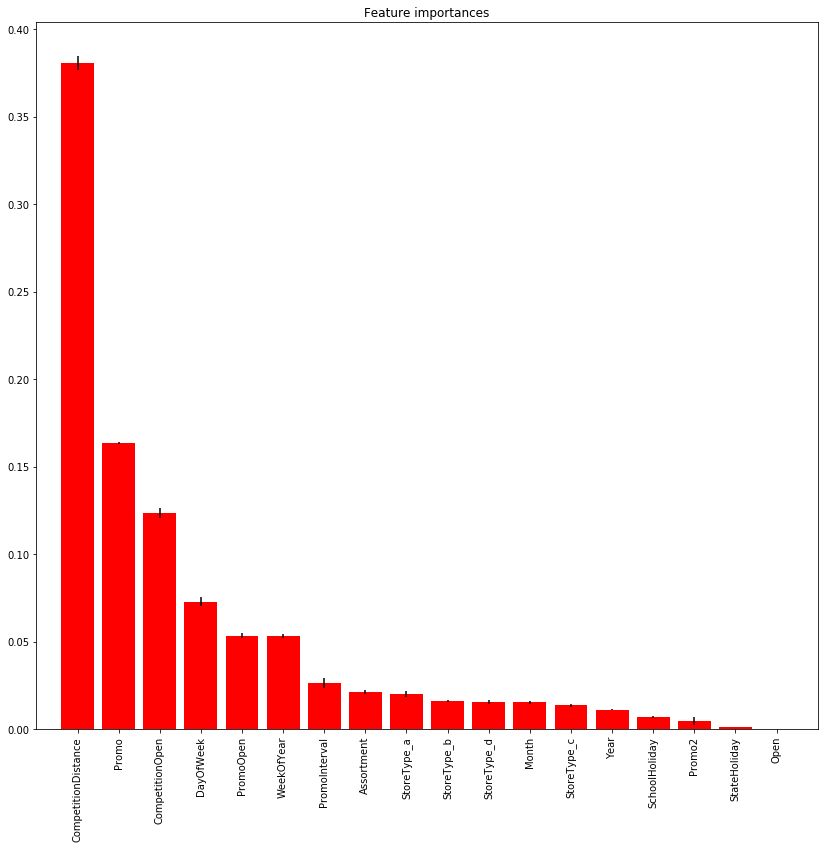

In [500]:
clf_rf_5 = RandomForestRegressor()      
clr_rf_5 = clf_rf_5.fit(X_trainWithSales,y_trainWithSales)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_trainWithSales.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_trainWithSales.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_trainWithSales.shape[1]), X_trainWithSales.columns[indices],rotation=90)
plt.xlim([-1, X_trainWithSales.shape[1]])
plt.show()